In [19]:
import numpy as np 
import nltk
from nltk.corpus import inaugural
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('brown')
nltk.download('punkt')
nltk.download('universal_tagset')
from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [7]:
## Data Processing
tagged_sentences = brown.tagged_sents(tagset='universal')
num_sentences = len(brown.tagged_sents())

START_SYMBOL = '^'
END_SYMBOL = '.'

sentences = []
for i in range(num_sentences):
    sentences.append(tagged_sentences[i])
    
for i in range(num_sentences):
    for j in range(len(sentences[i])):
        x = list(sentences[i][j])
        x[0] = x[0].lower()
        sentences[i].pop(j)
        sentences[i].insert(j, tuple(x))
        
for i in range(num_sentences):
    sentences[i] = [(START_SYMBOL, START_SYMBOL)] + sentences[i]
    
sentences_k_fold = [[], [], [], [], []]
for i in range(len(sentences)):
    sentences_k_fold[i%5].append(sentences[i])

In [8]:
## Transition Probabilities
def calculate_transition_probabilites(sentences):
    count_tags_bigram = {}
    for j in range(len(sentences)):
        for i, item in enumerate(sentences[j]):
            if(i == len(sentences[j])-1):
                continue
            
            tuple_tags = (sentences[j][i+1][1], sentences[j][i][1])
            if tuple_tags in count_tags_bigram.keys():
                count_tags_bigram[tuple_tags] += 1
                
            else:
                count_tags_bigram[tuple_tags] = 1
                
    probability_tags_bigram = {}
    total = 0
    for key in count_tags_bigram.keys():
        total += count_tags_bigram[key]
        
        
    for key in count_tags_bigram.keys():
        probability_tags_bigram[key] = count_tags_bigram[key]/total

    return probability_tags_bigram   


In [9]:
## Lexical Independence Probabilities / Emission Probability
def calculate_emission_probabilities(sentences):
    emission_probabilities_dict = {'.' : {'.' : 1}}

    for j in range(len(sentences)):
        for i, item in enumerate(sentences[j]):
            if(i == len(sentences[j])-1):
                continue
            
            if(sentences[j][i][1] in emission_probabilities_dict):
                if(sentences[j][i][0] in emission_probabilities_dict[sentences[j][i][1]]):
                    emission_probabilities_dict[sentences[j][i][1]][sentences[j][i][0]] += 1
                    
                else:
                    emission_probabilities_dict[sentences[j][i][1]][sentences[j][i][0]] = 1
                    
            else:
                emission_probabilities_dict[sentences[j][i][1]] = {}
                emission_probabilities_dict[sentences[j][i][1]][sentences[j][i][0]] = 1
                
    tags = list(emission_probabilities_dict.keys())
    for key1 in emission_probabilities_dict.keys():
        total = 0
        for key2 in emission_probabilities_dict[key1].keys():
            total += emission_probabilities_dict[key1][key2]
        
        for key3 in emission_probabilities_dict[key1].keys():
            emission_probabilities_dict[key1][key3] /= total
            
            
    return emission_probabilities_dict, tags

In [10]:
## Viterbi Algorithm
def viterbi_algorithm(tags, input_sent_tokenized, probability_tags_bigram, emission_probabilities_dict):
    viterbi_matrix = []
    ls = []
    for tag in tags:
        if((tag, '^') in probability_tags_bigram.keys()):
            if(input_sent_tokenized[0] in emission_probabilities_dict[tag].keys()):
                ls.append(('^', probability_tags_bigram[(tag, '^')] * emission_probabilities_dict[tag][input_sent_tokenized[0]]))
            
            else:
                ls.append(('^', 0))
        
        else:
            ls.append(('^', 0))
            
    viterbi_matrix.append(ls)

    tags = list(tags)
    for i in range(1, len(input_sent_tokenized)):
        ls = [] 
        for tag in tags:
            max_probability = 0
            max_tag = '$Can$'
            for j in range(len(viterbi_matrix[i-1])):
                if(viterbi_matrix[i-1][j][1] > 0):
                    prev_tag = tags[j]
                    prev_probability = viterbi_matrix[i-1][j][1]
                    
                    if (tag, prev_tag) in probability_tags_bigram.keys() and input_sent_tokenized[i] in emission_probabilities_dict[tag].keys():
                        total_probability  = prev_probability * probability_tags_bigram[(tag, prev_tag)] * emission_probabilities_dict[tag][input_sent_tokenized[i]]
                        if(total_probability > max_probability):
                            max_probability = total_probability
                            max_tag = prev_tag            
            
            ls.append((max_tag, max_probability))                
        viterbi_matrix.append(ls)  
        
    out = []        
    for i,item in enumerate(viterbi_matrix):
        max_val = -1
        max_tag = ''
        for x in item:
            if(x[1] > max_val):
                max_val = x[1]
                max_tag = x[0]
        if(i != 0): out.append((input_sent_tokenized[i-1], max_tag))
    return out

In [11]:
## Cross-Validation
def kfoldcv(sentences_k_fold):
    accuracy = []
    total = []
    confusion_matrix_dict = {}
    for i in range(5):
        sentences = []
        test_set = []
        accuracy_val = 0
        total_val = 0
        for j in range(5):
            if(i == j): 
                test_set = test_set + sentences_k_fold[j] 
            else:
                sentences = sentences + sentences_k_fold[j]
                
        probability_tags_bigram = calculate_transition_probabilites(sentences)
        emission_probabilities, tags = calculate_emission_probabilities(sentences)
        if(i == 1):
            for x in range(len(tags)):
                for y in range(len(tags)):
                    confusion_matrix_dict[(tags[x], tags[y])] = 0

        for sent in test_set:
            words = []
            corresponding_tags = []
            for item in sent:
                if(item == ('^', '^')): continue
                words.append(item[0])
                corresponding_tags.append(item[1])
                
            predicted_tags = viterbi_algorithm(tags, words, probability_tags_bigram, emission_probabilities)
            for k in range(len(predicted_tags)):
                if((predicted_tags[k][1], corresponding_tags[k]) in confusion_matrix_dict.keys()):
                    confusion_matrix_dict[(predicted_tags[k][1], corresponding_tags[k])] += 1
                if(predicted_tags[k][1] == corresponding_tags[k]):
                    accuracy_val = accuracy_val + 1
                total_val += 1
        
        accuracy.append(accuracy_val)
        total.append(total_val)
        
    return accuracy, total, confusion_matrix_dict, tags
        

In [41]:
accuracy, total, confusion_matrix_dict, tags = kfoldcv(sentences_k_fold)

accuracy_total = 0
for i in range(5):
    accuracy_total += accuracy[i]/total[i]
    
accuracy_total /= 5
print(f"ACCURACY: {accuracy_total}")

ACCURACY: 0.7380789672845618


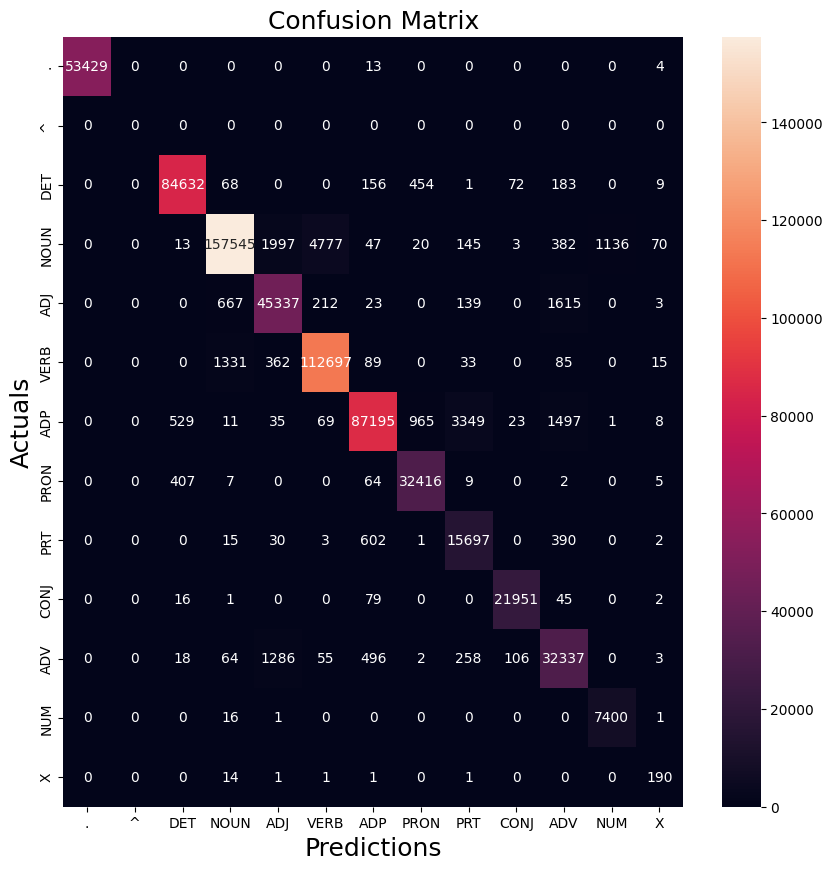

In [42]:
confusion_matrix = []
for i in range(len(tags)):
    ls = []
    for j in range(len(tags)):
        ls.append(0)
    confusion_matrix.append(ls)
    
    
for key in confusion_matrix_dict.keys():
    idx_1 = tags.index(key[0])
    idx_2 = tags.index(key[1])
    confusion_matrix[idx_1][idx_2] = confusion_matrix_dict[key]
   
fig, ax = plt.subplots(figsize=(10, 10))   
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels=tags, yticklabels=tags)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()